In [10]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from nltk.corpus import stopwords
from nltk.util import ngrams 
import random

from TweetProcessor import TweetProcessor as tp
tweet_processor = tp.TweetProcessor()

## TweetProcessor module demonstration using Airline twitter sentiment data
Data loading, preprocessing and feature selection. The selected features are combined TF-IDT features for text and emojis.

In [5]:
air_df = pd.read_csv('data/TwitterAirlineSentiment.csv')
air_df.drop_duplicates(inplace=True)

print("")
print("Starting feature selection...")
print("")
start = datetime.now()

#tokenize text and set the data and the target
air_df['tokenized_features'] = air_df['text'].apply(tweet_processor.tweet_pipeline)
X = air_df['tokenized_features'].apply(lambda x: ' '.join(x)).values
y = air_df['airline_sentiment'].values

# TF-IDF text features
vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = vectorizer.transform(X)

# TF-IDF emoji features
vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = vectorizer.transform(X)

# Combine features and split data to test and train sets
X_combined = np.hstack((X_tfidf.toarray(),X_emoji.toarray()))
x_train, x_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.2, random_state=0)

print('Finished feature selection in : ', datetime.now()-start)


Starting feature selection...

Finished feature selection in :  0:00:13.346617


Setup classifier, train and test. One VS rest classification using grid search and Bernoulli Naive Bayes with 2-fold crossvalidation.

In [6]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multiclass import OneVsRestClassifier

print("")
print("Starting OneVsRestClassifier BernoulliNB classifier...")
print("")
start = datetime.now()
pipeline = Pipeline([
                ('clf', OneVsRestClassifier(BernoulliNB()))
            ])

parameters = [{
            'clf__estimator__alpha': (0.001, 0.01, 0.4, 0.6, 0.8, 1),
            }]

grid_search_cv = GridSearchCV(pipeline, parameters, cv=2)

grid_search_cv.fit(x_train, y_train)

best_clf = grid_search_cv.best_estimator_

y_pred = best_clf.predict(x_test)
predict_proba = best_clf.predict_proba(x_test)
# Evaluation
accuracy = metrics.accuracy_score(y_test, y_pred)
precision = metrics.precision_score(y_test, y_pred, average='macro')
recall = metrics.recall_score(y_test, y_pred, average='macro')
f1_score = metrics.f1_score(y_test, y_pred, average='macro')
print('accuracy: %s' % accuracy)
print('precision: %s' % precision)
print('recall: %s' % recall)
print('f1_score: %s' % f1_score)

print(classification_report(y_test, y_pred))  
print(accuracy_score(y_test, y_pred))

print("")
print('Finished training in : ', datetime.now()-start) 
print(best_clf.get_params())


Starting OneVsRestClassifier BernoulliNB classifier...

accuracy: 0.7901403628894215
precision: 0.7313825206434631
recall: 0.7411200915281926
f1_score: 0.736024264289064
              precision    recall  f1-score   support

    negative       0.87      0.86      0.87      1823
     neutral       0.63      0.63      0.63       640
    positive       0.69      0.73      0.71       458

    accuracy                           0.79      2921
   macro avg       0.73      0.74      0.74      2921
weighted avg       0.79      0.79      0.79      2921

0.7901403628894215

Finished training in :  0:01:01.563577
{'memory': None, 'steps': [('clf', OneVsRestClassifier(estimator=BernoulliNB(alpha=0.8, binarize=0.0,
                                          class_prior=None, fit_prior=True),
                    n_jobs=None))], 'verbose': False, 'clf': OneVsRestClassifier(estimator=BernoulliNB(alpha=0.8, binarize=0.0,
                                          class_prior=None, fit_prior=True),
     

Visualize sentiment distribution

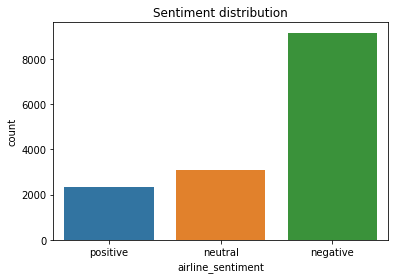

In [7]:
ax = sns.countplot(x="airline_sentiment", data=air_df, order=['positive', 'neutral', 'negative'])
ax.set_xticklabels(ax.get_xticklabels())
plt.title('Sentiment distribution')
plt.show()

Comparison between expectation and prediction

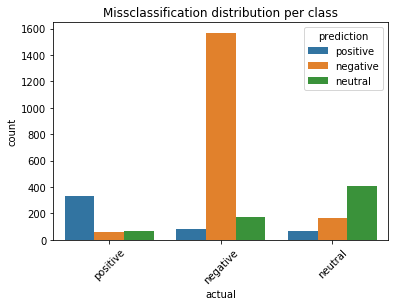

In [8]:
pred_df = pd.DataFrame(data=best_clf.predict_proba(x_test), columns=['negative', 'neutral', 'positive'])
pred_df['prediction'] = best_clf.predict(x_test)
pred_df['confidence'] = pred_df[['negative', 'neutral', 'positive']].values.max(axis=1)
pred_df['actual'] = y_test

ax = sns.countplot(x="actual", hue='prediction', data=pred_df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title('Missclassification distribution per class')
plt.show()

Display the ambiguity distribution. Neutral and positive predictions are the most ambiguous since their prediction probability of some example revolves around 0.5.

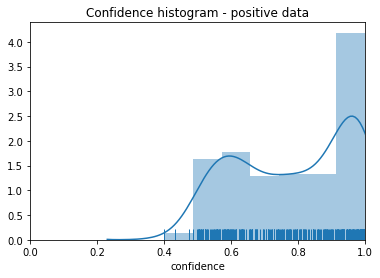

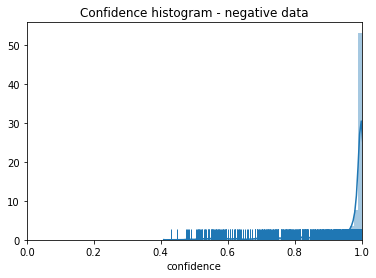

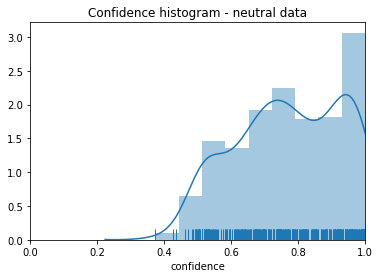

In [6]:
for pred in ['positive', 'negative', 'neutral']:
   data = pred_df[(pred_df['prediction']==pred) & (pred_df['actual']==pred)]
   axes = plt.gca()
   sns.distplot(data['confidence'], rug=True)
   axes.set_xlim([0,1])
   plt.title('Confidence histogram - %s data' % pred)
   plt.show()

Wordcloud visualization of sentiment for unigrams and bi/tri-grams

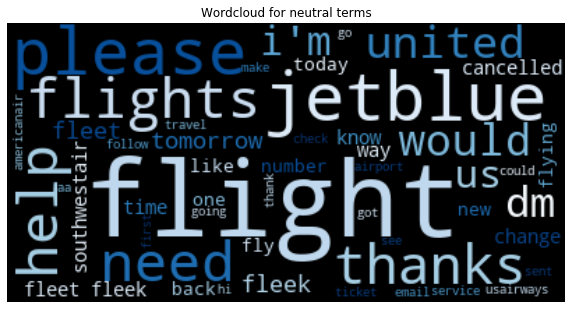

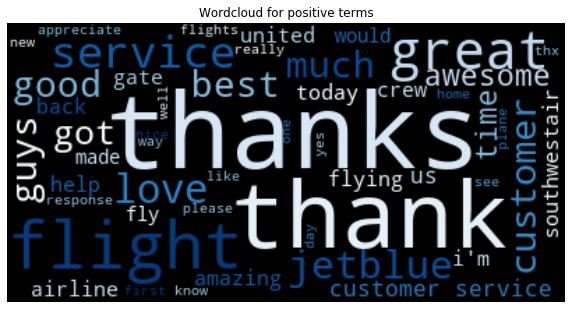

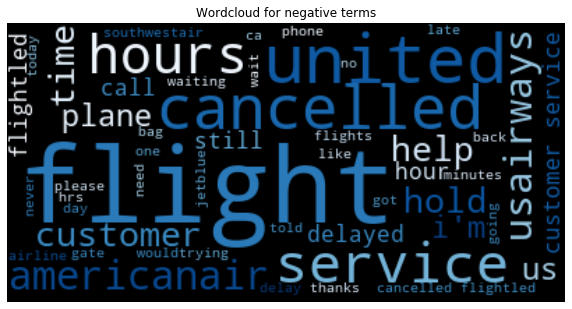

In [7]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

data_df = air_df.loc[:, ('tokenized_features', 'airline_sentiment')]
data_df.loc[:, ('tokenized_features')] = data_df['tokenized_features'].apply(lambda x: 
                                                                          [i for i in x 
                                                                              if i not in tweet_processor.custom_features_pos.keys()
                                                                              and i not in tweet_processor.emoji_vocabulary
                                                                              and i not in stopwords.words('english')])

for c in data_df['airline_sentiment'].unique():
   data = data_df[data_df['airline_sentiment']==c].loc[:, ('tokenized_features')].apply(lambda x: ' '.join(x)).values
   corpus = ' '.join(data).lower().split(' ')  
   # Capture bigrams and trigrams      
   bigrams_count = {' '.join(ngram):count for ngram,count in Counter(ngrams(corpus, 2)).most_common()}
   trigrams_count = {' '.join(ngram):count for ngram,count in Counter(ngrams(corpus, 3)).most_common()}   
   corpus_dict = dict(Counter(corpus).most_common())
   # Calculate word count for unigrams, bigrams and trigrams
   word_count = {**corpus_dict, **bigrams_count, **trigrams_count}
   # draw a Word Cloud with word frequencies
   wordcloud = WordCloud(max_words=50,
                         max_font_size=75,
                         colormap='Blues',
                         stopwords=stopwords.words('english')).generate_from_frequencies(word_count)
   plt.figure(figsize=(10,8))
   plt.title('Wordcloud for %s terms' % c)
   plt.imshow(wordcloud, interpolation='bilinear')
   plt.axis("off")
   plt.show()


### Apply model on immigration data

Data loading

In [8]:
#Load dataframe
immigration_df = pd.read_csv('data/tweet_immigration_db.csv')
# vectorize hashtags
immigration_df.dropna(subset=['hashtags'], inplace=True)
immigration_df.loc[:, 'hashtags'] = immigration_df['hashtags'].apply(lambda x: x.replace('[','').
                                                                                 replace(']','').
                                                                                 replace('\'','').
                                                                                 split(','))

immigration_df.describe()

/home/arvartho/python/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6,7,12,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,keyword,timestamp,username,screen_name,user_location,user_description,user_followers_count,user_friends_count,user_favourites_count,text,place,coordinates,favorite_count,hashtags,retweet_count,tokenized_features
count,66600,66600,66599,66600,66600,62064,66600.0,66600,66600,66600,1051,42,66600.0,66600,66600.0,66600
unique,15,4253,47435,48291,20948,45293,18967.0,13301,32634,66600,1035,38,56.0,7679,1183.0,60954
top,immigration,2020/03/21 12:50:02,VOICE OF REFUGEE,voice_4_refugee,United States,Helping Migrants Along the Way. Following what...,11.0,5001,0,"RT @P4tR10tBoo: On March 25, MONTANA State Sup...",Place(_api=<tweepy.api.API object at 0x7f381cd...,"{'type': 'Point', 'coordinates': [-77.0023, 38...",0.0,[],0.0,[]
freq,20055,80,263,263,1295,162,117.0,170,831,1,5,2,32164.0,51088,16663.0,482


Preprocessing and feature selection. The selected features are combined TF-IDT features for text and emojis.

In [9]:
print("")
print("Starting feature selection...")
print("")
start = datetime.now()

#tokenize text and set the data and the target
immigration_df['tokenized_features'] = immigration_df['text'].apply(tweet_processor.tweet_pipeline)
X = immigration_df['tokenized_features'].apply(lambda x: ' '.join(x)).values

# TF-IDF text features
vectorizer = tweet_processor.tfidf_vectorizer(X)
X_tfidf = vectorizer.transform(X)

# TF-IDF emoji features
vectorizer = tweet_processor.emoji_vectorizer(X)
X_emoji = vectorizer.transform(X)

# Combine features and split data to test and train sets
x_test = np.hstack((X_tfidf.toarray(),X_emoji.toarray()))

print('Finished feature selection in : ', datetime.now()-start)


Starting feature selection...

Finished feature selection in :  0:01:09.016851


Apply previously trained classifier to data

In [10]:
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.multiclass import OneVsRestClassifier

print("")
print("Starting OneVsRestClassifier BernoulliNB classifier...")
print("")
start = datetime.now()

y_pred = best_clf.predict(x_test)
predict_proba = best_clf.predict_proba(x_test)

print("")
print('Finished training in : ', datetime.now()-start) 
print(best_clf.get_params())


Starting OneVsRestClassifier BernoulliNB classifier...


Finished training in :  0:00:43.537506
{'memory': None, 'steps': [('clf', OneVsRestClassifier(estimator=BernoulliNB(alpha=0.8, binarize=0.0,
                                          class_prior=None, fit_prior=True),
                    n_jobs=None))], 'verbose': False, 'clf': OneVsRestClassifier(estimator=BernoulliNB(alpha=0.8, binarize=0.0,
                                          class_prior=None, fit_prior=True),
                    n_jobs=None), 'clf__estimator__alpha': 0.8, 'clf__estimator__binarize': 0.0, 'clf__estimator__class_prior': None, 'clf__estimator__fit_prior': True, 'clf__estimator': BernoulliNB(alpha=0.8, binarize=0.0, class_prior=None, fit_prior=True), 'clf__n_jobs': None}


Visualize sentiment distribution

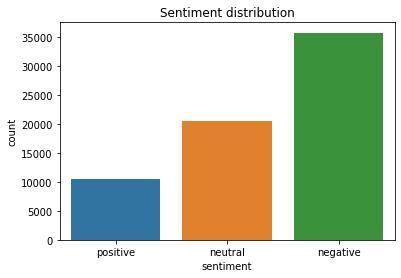

In [11]:
immigration_df['sentiment'] = y_pred
ax = sns.countplot(x="sentiment", data=immigration_df, order=['positive', 'neutral', 'negative'])
ax.set_xticklabels(ax.get_xticklabels())
plt.title('Sentiment distribution')
plt.show()

Display the prediction uncertainty

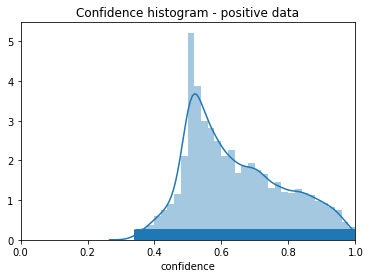

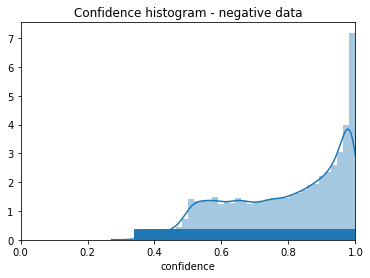

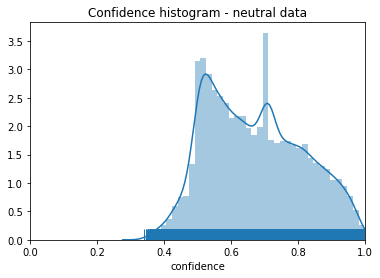

In [12]:
pred_df = pd.DataFrame(data=predict_proba, columns=['negative', 'neutral', 'positive'])
pred_df['prediction'] = best_clf.predict(x_test)
pred_df['confidence'] = pred_df[['negative', 'neutral', 'positive']].values.max(axis=1)

for pred in ['positive', 'negative', 'neutral']:
   data = pred_df[(pred_df['prediction']==pred)]
   axes = plt.gca()
   sns.distplot(data['confidence'], rug=True)
   axes.set_xlim([0,1])
   plt.title('Confidence histogram - %s data' % pred)
   plt.show()

Wordcloud visualization of sentiment for unigrams and bi/tri-grams

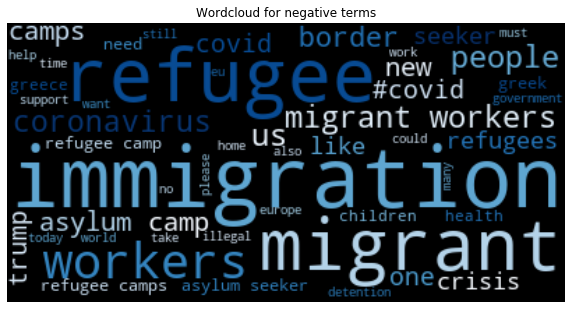

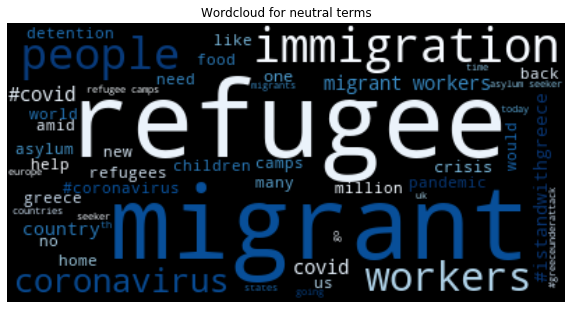

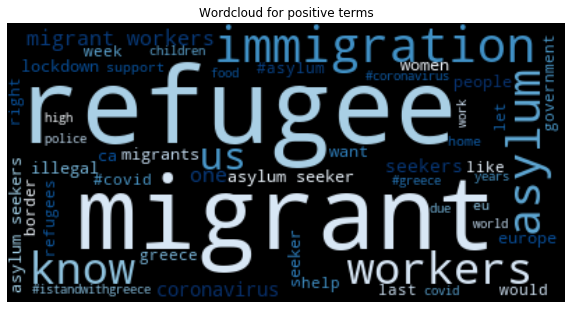

In [13]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

data_df = immigration_df.loc[:, ('tokenized_features', 'sentiment')]
data_df.loc[:, ('tokenized_features')] = data_df['tokenized_features'].apply(lambda x: 
                                                                          [i for i in x 
                                                                              if i not in tweet_processor.custom_features_pos.keys()
                                                                              and i not in tweet_processor.emoji_vocabulary
                                                                              and i not in stopwords.words('english')])

for c in immigration_df['sentiment'].unique():
   data = data_df[data_df['sentiment']==c].loc[:, ('tokenized_features')].apply(lambda x: ' '.join(x)).values
   corpus = ' '.join(data).lower().split(' ')  
   # Capture bigrams and trigrams      
   bigrams_count = {' '.join(ngram):count for ngram,count in Counter(ngrams(corpus, 2)).most_common()}
   trigrams_count = {' '.join(ngram):count for ngram,count in Counter(ngrams(corpus, 3)).most_common()}   
   corpus_dict = dict(Counter(corpus).most_common())
   # Calculate word count for unigrams
   word_count = {**corpus_dict, **bigrams_count, **trigrams_count}
   # draw a Word Cloud with word frequencies
   wordcloud = WordCloud(max_words=50,
                         max_font_size=75,
                         colormap='Blues',
                         stopwords=stopwords.words('english')).generate_from_frequencies(word_count)
   plt.figure(figsize=(10,8))
   plt.title('Wordcloud for %s terms' % c)
   plt.imshow(wordcloud, interpolation='bilinear')
   plt.axis("off")
   plt.show()
   